# Link Prediction and Network Inference
**Blas Kolic 2025**

In this tutorial, we will learn how to train a machine learning model to predict missing/future links in a network. 

Real networks are noisy (we may not observe some interactions that did happen) and dynamic (new interactions happen over time). The idea here is that, given the usual characteristics of many empirical networks (e.g., high tradic closure, homophily, small-worldness), we can extract relevant characteristics as features and train a good-enough model that highly scores very probable missing or future interactions. 

First, we will compute some these characteristics by hand in a small network to gain some intuition. Then, we will move into a larger real network and build a machine learning pipeline using the concepts we saw in class.

**Outline of the tutorial**
1. **Analyze a small network**: Compute similarity features and visualize them.
2. **Link prediction model in bigger network**: Scale it up and build a machine learning pipeline for link prediction.
   1. Read, preprocess, and create a `networkx` network
   2. Create a training sample based on existing and non-existing links
   3. Compute a similarity score table for the sampled links
   4. Train a machine learning model with the features and sampled links
   5. Evaluate model performance
3. **Optional exercises**

In [1]:
import numpy as np # numerical operations
import pandas as pd # dataframes and tables
import networkx as nx # networks
import matplotlib.pyplot as plt # visualizations

## Building intuition by eye

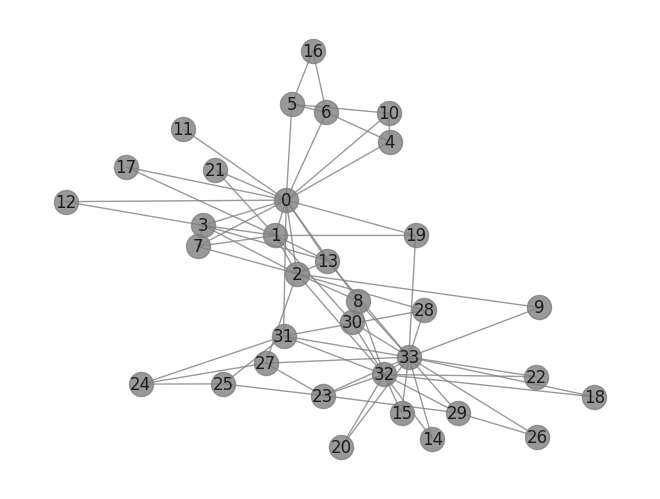

In [2]:
# As a first example, let's analyze the Karate Club graph
G = nx.karate_club_graph() 

# Visualize the graph
pos = nx.spring_layout(G, seed=0)
nx.draw(G, pos=pos, with_labels=True, node_color='gray', alpha=0.8, edge_color='gray')

For nodes 28 and 32, common neighbors are: {33, 2, 31}


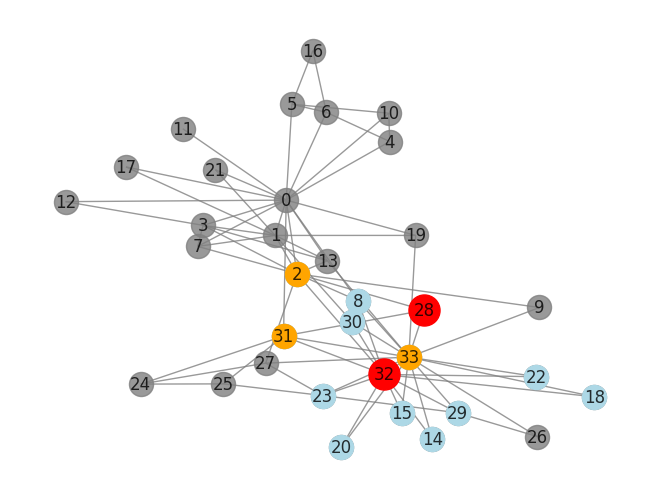

In [3]:
# Select two nodes
u, v = 28, 32

# Find common neighbors
nu = set( nx.neighbors(G, u) )
nv = set( nx.neighbors(G, v) )
common_neigh = nu.intersection(nv)  # you can also use nx.common_neighbors 
print(f"For nodes {u} and {v}, common neighbors are: {common_neigh}")

# Illustrate this
nx.draw(G, pos=pos, with_labels=True, node_color='gray', alpha=0.8, edge_color='gray')
nx.draw_networkx_nodes(G, pos=pos, nodelist=list(nu.union(nv)), node_color='lightblue') # highlight neighbors
nx.draw_networkx_nodes(G, pos=pos, nodelist=list(common_neigh), node_color='orange') # highlight common neighbors
nx.draw_networkx_nodes(G, pos=pos, nodelist=[u, v], node_color='red', node_size=500) # highlight u and v

In [4]:
# Now, let's compute similarity scores between these two nodes
# Jaccard Coefficient
intersection_size = len(common_neigh)
union_size = len(nu.union(nv))
jaccard_coeff = intersection_size / union_size
print(f"Jaccard Coefficient: {round(jaccard_coeff,2)}")

# OBS: we can also use nx.jaccard_coefficient (gives error if a node doesn't have neighbors)
list(nx.jaccard_coefficient(G, [(u,v)]))

Jaccard Coefficient: 0.25


[(28, 32, 0.25)]

In [5]:
# Adamic/Adar Index
adamic_adar = sum(1 / np.log(len(list(nx.neighbors(G, w)))) for w in common_neigh)
print(f"Adamic/Adar Index: {round(adamic_adar,2)}")

# OBS: we can also use nx.adamic_adar_index (gives error if a node doesn't have neighbors)
list(nx.adamic_adar_index(G, [(u,v)]))

Adamic/Adar Index: 1.35


[(28, 32, 1.34536123231926)]

In [6]:
# Preferential Attachment
preferential_attachment = len(nu) * len(nv)
print(f"Preferential Attachment Score: {preferential_attachment}")

# OBS: we can also use nx.preferential_attachment
list(nx.preferential_attachment(G, [(u,v)]))

Preferential Attachment Score: 36


[(28, 32, 36)]

In [7]:
# Inverse Path Distance
path_length = nx.shortest_path_length(G, source=u, target=v)
inverse_path_distance = 1/path_length if path_length > 0 else 0
print(f"Inverse Path Distance: {round(inverse_path_distance,2)}")

Inverse Path Distance: 0.5


For nodes 28 and 5, common neighbors are: set()


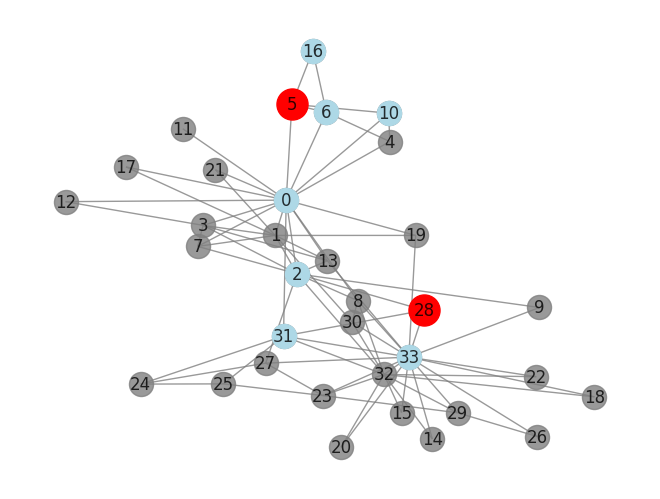

In [8]:
# Select two other nodes
u, v = 28, 5

# Find common neighbors
nu = set( nx.neighbors(G, u) )
nv = set( nx.neighbors(G, v) )
common_neigh = nu.intersection(nv)  # you can also use nx.common_neighbors 
print(f"For nodes {u} and {v}, common neighbors are: {common_neigh}")

# Illustrate this
nx.draw(G, pos=pos, with_labels=True, node_color='gray', alpha=0.8, edge_color='gray')
nx.draw_networkx_nodes(G, pos=pos, nodelist=list(nu.union(nv)), node_color='lightblue') # highlight neighbors
nx.draw_networkx_nodes(G, pos=pos, nodelist=list(common_neigh), node_color='orange') # highlight common neighbors
nx.draw_networkx_nodes(G, pos=pos, nodelist=[u, v], node_color='red', node_size=500) # highlight u and v

In [9]:
# Jaccard Coefficient
intersection_size = len(common_neigh)
union_size = len(nu.union(nv))
jaccard_coeff = intersection_size / union_size if union_size > 0 else 0
print(f"Jaccard Coefficient: {round(jaccard_coeff,2)}")

# Adamic/Adar Index
adamic_adar = sum(1 / np.log(len(list(nx.neighbors(G, w)))) for w in common_neigh)
print(f"Adamic/Adar Index: {round(adamic_adar,2)}")

# Preferential Attachment
preferential_attachment = len(nu) * len(nv)
print(f"Preferential Attachment Score: {preferential_attachment}")

# Inverse Path Distance
path_length = nx.shortest_path_length(G, source=u, target=v)
inverse_path_distance = 1/path_length if path_length > 0 else 0
print(f"Inverse Path Distance: {round(inverse_path_distance,2)}")

# Using built-ins
(
    list(nx.jaccard_coefficient(G, [(u,v)]))[0][-1],
    list(nx.adamic_adar_index(G, [(u,v)]))[0][-1],
    list(nx.preferential_attachment(G, [(u,v)]))[0][-1],
    1/nx.shortest_path_length(G,u,v),
)

Jaccard Coefficient: 0.0
Adamic/Adar Index: 0
Preferential Attachment Score: 12
Inverse Path Distance: 0.33


(0.0, 0, 12, 0.3333333333333333)

We observe that nodes $(28,32)$ are much likely to form a link than nodes $(28, 5)$, which is reflected in much lower values of their *similarity scores*.

## Predicting future links in a real network

Now, let's try to predict future interactions based on past ones using similarity scores as features. We'll use historical data on Facebook wall posts of a random subset of Facebook users during 2008. Using 2008, we will predict the interactions at early 2009.

To do so, we will:
1. Load the real *temporal* Facebook network where interactions are timestamped.
2. Remove the most recent interactions (early 2009) and assume we want to predict them
3. Create similarity features between pairs of nodes
4. Train a machine learning model that predicts the most probable future interactions
5. Analyze the performance of our model


The data is publicly available in the [Netzschleuder repository](https://networks.skewed.de/net/facebook_wall) and was used in this paper:
> Viswanath, Bimal, et al. "On the evolution of user interaction in facebook." Proceedings of the 2nd ACM workshop on Online social networks. 2009.

### Read and create network
- We first read the network edgelist from `'./data/fb_wall_posts/edges.csv'`
- We convert the `'time'` column into a Datetime object
- We only keep interactions from 2008 on
- We create the network using `networkx`

In [10]:
# Read edgelist with format (source, target, weight, timestamp)
edgelist = pd.read_csv('./data/fb_wall_posts/edges.csv')
# Rename column names (remove clutter)
col_names = [col.replace('# ', '').strip() for col in edgelist.columns]
edgelist.columns = col_names
edgelist.head()

,source,target,weight,time
0,0,0,1,1095135831
1,1,2,1,1097725406
2,1,2,1,1098489762
3,1,2,1,1098673897
4,1,2,1,1099602800


,source,target,weight,time,date
70,1,10608,1,1199330542,2008-01-03 03:22:22
71,1,871,1,1200518315,2008-01-16 21:18:35
72,1,5401,1,1204580284,2008-03-03 21:38:04
73,1,11185,1,1204598711,2008-03-04 02:45:11
74,1,5401,1,1204647694,2008-03-04 16:21:34


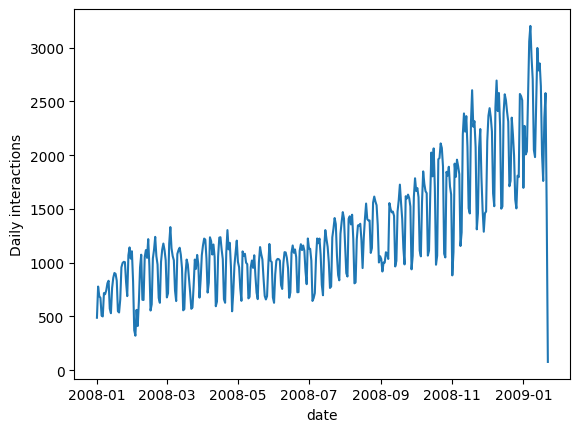

In [11]:
# Consider only edges from 2008 onwards (recent edges)
edgelist['date'] = pd.to_datetime(edgelist['time'], unit='s')
time_mask = edgelist['date'] >= pd.to_datetime('2008-01-01')
edgelist = edgelist[time_mask]

# Plot timestamp distribution
edgelist['date'].dt.date.value_counts().sort_index().plot()
plt.ylabel('Daily interactions')

edgelist.head()

In [12]:
# Create network from aggregated edgelist
edgelist_agg = edgelist.groupby(['source','target'])['weight'].sum().reset_index(name='weight')
G = nx.from_pandas_edgelist(edgelist_agg, edge_attr='weight', create_using=nx.Graph)
print(f"G has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

G has 44609 nodes and 146663 edges.


### Preparing observed network
- We assume we only observe the network during 2008, so
  - We remove the edges accounting for the last month of interactions (Jan 2009)
  - We tag the removed edges as a positive label class which we will use for training later
  - We also sample non-existent edges at random to have a negative label class
    - We create the helper function `sample_non_existing_edges` 
- We create a training sample (postive + negative edges from 2009)
- Our observations only account for interactions during 2008

In [13]:
# Remove last month of interactions from G_observed to create test positive samples
G_observed = G.copy()
period_test = edgelist['date'].max() - pd.Timedelta(days=30) # Consider last month of interactions

# We're going to remove this edges and tag them as the positive class
edges_pos = edgelist[ (edgelist['date'] >= period_test) ]
edges_pos = edges_pos[['source','target']].drop_duplicates().values
print(f"Number of positive interactions in test period: {len(edges_pos)}")

# Remove these edges (they haven't happened yet in the observed network)
G_observed.remove_edges_from(edges_pos)

print(f"True network has {G.number_of_edges()} edges, observed network has {G_observed.number_of_edges()} edges.")

Number of positive interactions in test period: 43742
True network has 146663 edges, observed network has 114753 edges.


In [14]:
# helper to sample negative edges
def sample_non_existing_edges(G, num_samples):
    """Sample 'num_samples' pairs of nodes (u, v) that are NOT connected by an edge in G."""
    nodes = list(G.nodes())
    
    non_existing_links = []
    while len(non_existing_links) < num_samples:        
        # sample two random nodes
        u, v = np.random.choice(nodes, size=2, replace=False)

        # check if they are not connected
        if u != v and not G.has_edge(u, v):
            non_existing_links.append( [u, v] )

    return np.array(non_existing_links)

# Sample non-existing links at random (might take ~1 minute)
%time edges_neg = sample_non_existing_edges(G_observed, num_samples=len(edges_pos))

CPU times: user 1min 6s, sys: 412 ms, total: 1min 7s
Wall time: 1min 7s


In [15]:
# Concatenate positive and negative links
edges_total = np.vstack( [edges_pos, edges_neg] )

# Create labels for the edges: 1 for existing edges, 0 for non-existing edges
labels = [1] * len(edges_pos) + [0] * len(edges_neg)

# Balanced dataset
print(f"Number of positive links: {len(edges_pos)}; negative links: {len(edges_neg)}")

Number of positive links: 43742; negative links: 43742


We now have a collection of existing links (`edges_pos`) and non-existing links (`edges_neg`). This will represent the postive and negative classes with which we will train our machine learning models.

### Computing similarity scores of selected links
Now, we will compute the similarity scores we saw in class. To do so, we will create helper function `compute_features` that compiles all the scores for all selected edges and format it into a `pandas` DataFrame.

Then, we will analyze the feature correlations and the distribution of features between positive and negative links.


In [16]:
# link prediction helpers
def compute_features(G, link_list):
    """Compute link prediction features for a list of links in graph G."""
    # Precompute neighbors dictionary for all nodes
    neighbors = {u: set(nx.neighbors(G, u)) for u in G}

    # Initialize feature lists
    common_neighs = []
    jaccard_coeffs = []
    pref_attachs = []
    adamic_adars = []
    distances = []

    # Loop over each link and compute features
    for u, v in link_list:
        
        # Get neighbors of u and v (if node not in graph, use empty set)
        nu = neighbors.get(u, set())
        nv = neighbors.get(v, set())
        n_uv = nu.union(nv)
        
        # Compute similarity features
        common_neighs_uv = nu.intersection(nv)
        pref_attach_uv = len(nu) * len(nv)
        jaccard_uv = len(common_neighs_uv)/len(n_uv) if len(n_uv) != 0 else 0        
        try:
            aa_uv = list( nx.adamic_adar_index(G, [(u,v)]) )[0][-1]
        except:
            aa_uv = 0 # Adamic-adar might break for isolated neighbors
        
        try:
            dist_uv = 1/nx.shortest_path_length(G,u,v)
        except:
            dist_uv = 0 # There might not be a path from u to v
    
        # Append features to list
        common_neighs.append( len(common_neighs_uv) )
        pref_attachs.append( pref_attach_uv )
        jaccard_coeffs.append( jaccard_uv )
        adamic_adars.append( aa_uv )
        distances.append( dist_uv )

    # Create a DataFrame with all features
    features_df = pd.DataFrame({
        'num_common_neigh': common_neighs,
        'jaccard_coeff': jaccard_coeffs,
        'pref_attach': pref_attachs,
        'adamic_adar': adamic_adars,
        'distance_inv': distances,
    })

    return features_df

In [17]:
# First, compute features for the collection of edges
features = compute_features(G_observed, edges_total)
features

,num_common_neigh,jaccard_coeff,pref_attach,adamic_adar,distance_inv
0,0,0.000000,72,0.000000,0.333333
1,4,0.160000,204,2.684995,0.500000
2,4,0.075472,602,1.510273,0.500000
3,0,0.000000,112,0.000000,0.200000
4,2,0.060606,306,0.688117,0.500000
...,...,...,...,...,...
87479,0,0.000000,12,0.000000,0.142857
87480,0,0.000000,6,0.000000,0.166667
87481,0,0.000000,3,0.000000,0.000000
87482,0,0.000000,94,0.000000,0.250000


In [18]:
# Let's check the correlation between features
features.corr()

,num_common_neigh,jaccard_coeff,pref_attach,adamic_adar,distance_inv
num_common_neigh,1.000000,0.567516,0.506010,0.786679,0.383853
jaccard_coeff,0.567516,1.000000,0.101622,0.545292,0.226516
pref_attach,0.506010,0.101622,1.000000,0.449092,0.398087
adamic_adar,0.786679,0.545292,0.449092,1.000000,0.472148
distance_inv,0.383853,0.226516,0.398087,0.472148,1.000000


Remove features that are highly correlated, as they might hurt the machine learning model. For example, we see that `adamic_adar` has a correlation $>0.6$ with both `num_common_neighbors` and `jaccard_coeff`.

In [19]:
# Remove the 'num_common_neigh' feature: high correlation with 'jaccard_coeff' and 'adamic_adar'
unecessary_features = ['num_common_neigh', 'jaccard_coeff']
features = features.drop(columns=unecessary_features)

In [20]:
# Include the label class we constructed above (postive = 1, negative = 0)
features['label'] = labels
features

,pref_attach,adamic_adar,distance_inv,label
0,72,0.000000,0.333333,1
1,204,2.684995,0.500000,1
2,602,1.510273,0.500000,1
3,112,0.000000,0.200000,1
4,306,0.688117,0.500000,1
...,...,...,...,...
87479,12,0.000000,0.142857,0
87480,6,0.000000,0.166667,0
87481,3,0.000000,0.000000,0
87482,94,0.000000,0.250000,0


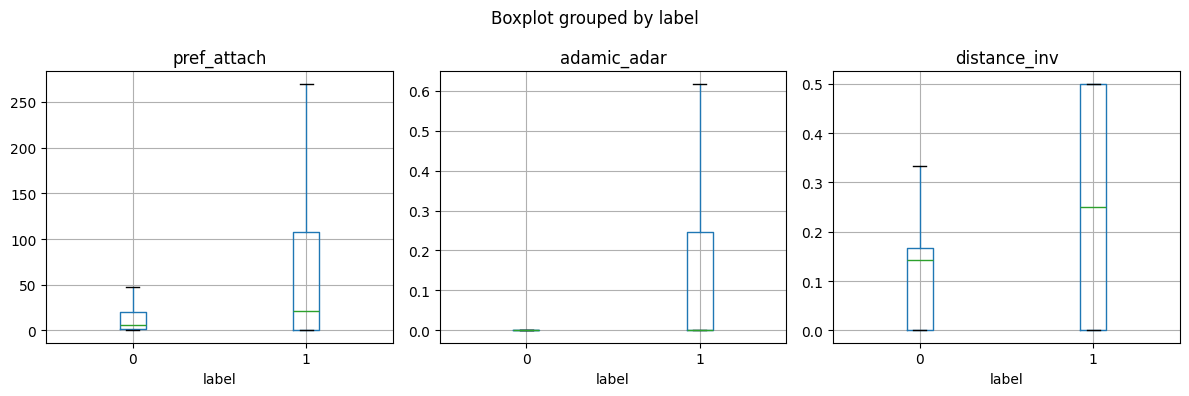

In [21]:
# Visualize feature distributions by label class
feature_names = features.columns[:-1]  # Exclude the label column

# Create subplots for each feature
fig, ax = plt.subplots(ncols=len(feature_names), figsize=(12, 4))
for i,feat in enumerate(feature_names):
    features[[feat, 'label']].boxplot(by='label', column=feat, showfliers=False, ax=ax[i])

plt.tight_layout();

We can observe significant differences between label classes for each of the features. When the label is positive, the feature tends to be higher. This gives us hope that future links are somewhat predictable.

Now it's time to import the heavy machinery: `sklearn`. This package will let us create machine learning models very easily. Moreover, we will be able to analyze performance easily as well.

### Training and evaluating a machine learning model
Now, we will use `sklearn` package to:
1. Preprocess the data
   1. Scale the data so all features are in the same scale (mean = 0, std = 1)
   2. Split the edges into train/test sets so we can measure performance out of sample
2. Create a prediction model, where we will consider:
   1. A logistic regression: common linear statistical model (`LogisticRegression` in `sklearn`)
   2. A random forest classifier: common machine learning model (`RandomForestClassifier` in `sklearn`)
3. Train the prediction model with the train set
4. Measure performance on the test set with several metrics:
   1. Standard performance metrics (Precision, Recall, F1, AUC)
   2. Assessing the confusion matrix (true/false positives/negatives)
   3. Plotting the ROC curve
   4. Plotting the prediction score distribution
   5. Checking the importance of each of the features using *variable importance methods*

In [22]:
# sklearn imports (for ML model training and processing)
from sklearn.model_selection import train_test_split # help split data into train and test sets
from sklearn.preprocessing import StandardScaler # help scale features (e.g., zero mean, unit variance)
from sklearn.linear_model import LogisticRegression # logistic regression model
from sklearn.ensemble import RandomForestClassifier # random forest model
from sklearn.pipeline import Pipeline # Let's us link processing stages together very easily

#### Train model
The typical pipeline for training a model is:
1. Divide the data in train/test splits
2. Preprocess the data
3. Choose and train a model

`sklearn` has a convenient way of linking all of this together using the `Pipeline` method. Instead of first preprocessing the data manually and then training the model with the pre-processed data, we define a *pipeline* object that considers all the necessary steps when fitting the model.

In [23]:
# Create feature and label arrays
X = features.drop(columns=['label'])
y = features['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
# Create a pipeline with scaling (preprocessing) and model
pipe = Pipeline([
    ('scaling', StandardScaler()), # 1. Scale the data (so features have mean=0 and std=1)
    ('model', RandomForestClassifier(n_estimators=300)) # 2. Define the model (try using LogisticRegression(penalty='l2') too)
])

# Train the model by fitting the pipeline
## Obs: this is equivalent to 1. Scaling the data, 2. Fitting the model
pipe.fit(X_train, y_train)

,steps,"[('scaling', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2


In [25]:
# Prediction
y_prob = pipe.predict_proba(X_test)[:, 1] # prediction scores for positive class (between 0 and 1)
y_pred = pipe.predict(X_test) # class labels (0 or 1)

#### Assess model quality

In [26]:
# Check typical performance statistics
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_prob) 
print("ROC AUC Score:", round(auc, 2))

              precision    recall  f1-score   support

           0       0.75      0.72      0.74     13118
           1       0.73      0.76      0.75     13128

    accuracy                           0.74     26246
   macro avg       0.74      0.74      0.74     26246
weighted avg       0.74      0.74      0.74     26246

ROC AUC Score: 0.82


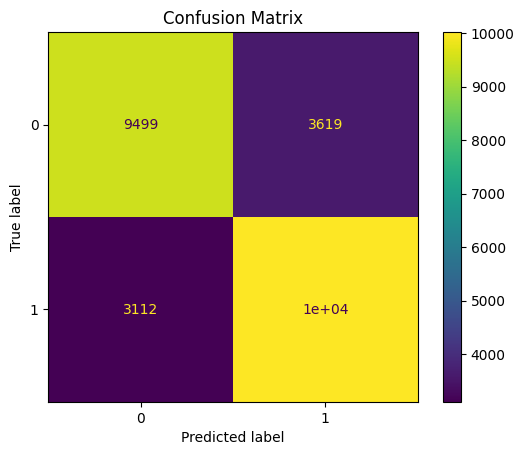

In [27]:
# Check the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
plt.title("Confusion Matrix");

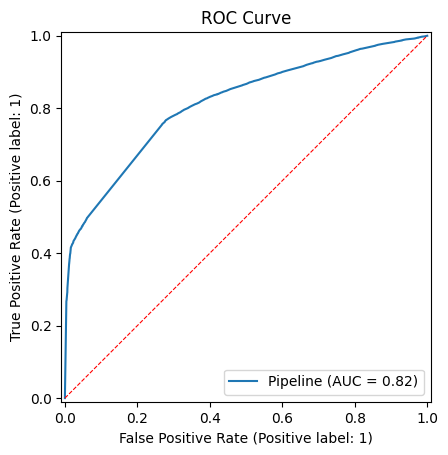

In [28]:
# Check the ROC curve and AUC score
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.plot([0,1],[0,1], color='r', ls='--', lw=0.8)
plt.title("ROC Curve");

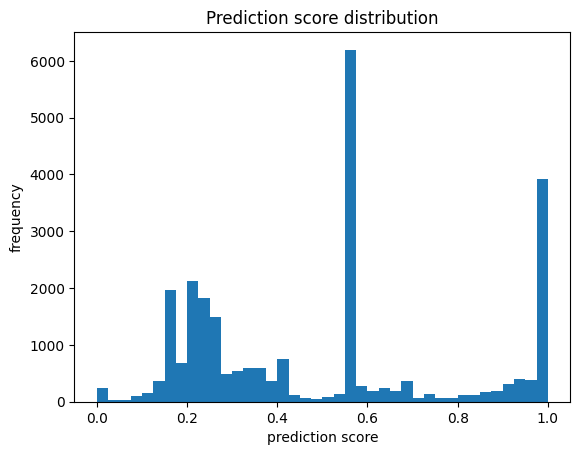

In [29]:
# Check the prediction score distribution
plt.hist(y_prob, bins=40)
plt.xlabel('prediction score')
plt.ylabel('frequency');
plt.title("Prediction score distribution");

In [30]:
# Checl the importance of variables using permutation importance
from sklearn.inspection import permutation_importance

feature_importance = permutation_importance(pipe, X_test, y_test, n_repeats=10, scoring='roc_auc')
pd.DataFrame({
    "feature": X.columns,
    "importance_mean": feature_importance.importances_mean,
    "importance_std": feature_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

,feature,importance_mean,importance_std
2,distance_inv,0.176443,0.002005
0,pref_attach,0.079894,0.002855
1,adamic_adar,0.048348,0.000723


From this model, we can see that:
1. It is good in the sense that it has an accuracy of ~75%
2. It is equally good across classes, so it's well balanced
3. It has a big uncertainty in many of the possible interactions (huge peak near 0.5)
4. The `distance` between nodes is the most important predictor: the closer they are in this network, the more likely they will be linked in the future.
5. `adamic adar` and `preferential attachment` have a huge amount of zeros, so they cannot be super informative/important

## Exercises (Optional)

1. **Is the model overfitting?** Many times, machine learning models find artificial patterns. A good way to analyze overfitting is checking whether the model performance in the train set is considerably better than in the test test. Check it yourself and discuss.
2. **Model comparison.** Create and train a logistic regression (`sklearn`'s `LogisticRegression`). Compare the performance for both models. Is there a clear winner? Does any model has specific strengths against the other? Code and discuss.
3. **Cross validation.** To ensure that a model is robust, it is common to make several spilts of the train/test sets and check that the good performance holds in all of them. This is called *cross validation*, and it's very easy to do with `sklearn`. Do cross validation with 5 splits
   1. First, `from sklearn.model_selection import cross_val_score`
   2. `cross_val_score` takes as input 
      1. the model (or pipeline) 
      2. the features `X` (not divided into train/test)
      3. the labels `y`
      4. the number of splits `cv`
      5. the `scoring` function. 
   3. It looks something like `cross_val_score(model, X=X, y=y, cv=5, scoring='roc_auc')`.
   4. Now, assess whether the model is robust by answering: What's the average score? How much does it vary?